# Price Anomaly Detection
The aim of this project is to use two features (Standard Deviation and Kurtosis) extracted from price points distribution of each product from each store to detect price anomalies in sales history.

Two approaches has been applied:
- Using quantile as threshold
- Clustering: Kmeans, Meanshift and DBSCAN

## Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# The step of connecting to database has been removed.

## Read data

In [4]:
sales = pd.read_sql('''
                            SELECT *
                            FROM SALES_HISTORY_02242020
                            ''', connection)

In [5]:
sales.head()

,WEEKLY_SALES_DATE,PRODUCT_ID,STORE_ID,CATEGORY,STORE_GROUP,SALES_TYPE_ID,SALES_PRICE,QUANTITY,REVENUE
0,2018-01-14,1081,03,03,2,1,15.98,6.0,95.88
1,2018-01-21,1081,03,03,2,1,15.98,8.0,127.84
2,2018-01-28,1081,03,03,2,1,15.98,9.0,143.82
3,2018-02-04,1081,03,03,2,2,12.98,29.0,376.42
4,2018-02-04,1081,03,03,2,1,15.98,3.0,47.94


In [6]:
sales.shape

(2108522, 9)

In [7]:
# Choose sales['SALES_TYPE_ID']==1 which is not promote price
sales_trimmed = sales[sales['SALES_TYPE_ID'] == '1'].copy()

In [8]:
sales_trimmed.head()

,WEEKLY_SALES_DATE,PRODUCT_ID,STORE_ID,CATEGORY,STORE_GROUP,SALES_TYPE_ID,SALES_PRICE,QUANTITY,REVENUE
0,2018-01-14,1081,03,03,2,1,15.98,6.0,95.88
1,2018-01-21,1081,03,03,2,1,15.98,8.0,127.84
2,2018-01-28,1081,03,03,2,1,15.98,9.0,143.82
4,2018-02-04,1081,03,03,2,1,15.98,3.0,47.94
7,2018-03-04,1081,03,03,2,1,15.98,2.0,31.96


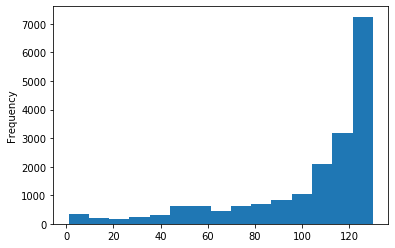

In [9]:
# check the sales missing weeks
sales_trimmed.groupby(['STORE_ID','PRODUCT_ID']).count()['WEEKLY_SALES_DATE'].sort_values().plot.hist(bins = 15)
# if the product is not sold for some weeks, there will be no rows for these weeks in the dataset.
# for price anomaly detection, we do not apply forward filling.

## Extract two feasures Kurtosis and Std_dev of each product in each store 

In [11]:
# 1 means only price type 1 which is not promotion price
sales_1 = sales_trimmed[['STORE_ID','PRODUCT_ID','SALES_PRICE']].groupby(['STORE_ID','PRODUCT_ID'])

In [12]:
# Kurtosis and Std_dev for price type 1
metrics_1 = sales_1.apply(pd.DataFrame.kurt)[['SALES_PRICE']]
metrics_1.columns = ['KURT']
metrics_1['SD'] = sales_1.apply(pd.DataFrame.std)

In [13]:
metrics_1.sort_values(['KURT'], ascending = False).head()

KURT        SD
STORE_ID PRODUCT_ID                 
15       0577        130.0  0.001754
02       0282        130.0  0.043853
15       1148        130.0  0.006139
         0499        130.0  0.052623
08       0393        130.0  0.064902

In [14]:
# Check the statistical summary of each metric
print('\n', 'KURTOSIS')
print(metrics_1['KURT'].describe())
print('\n', 'STD_DEV')
print(metrics_1['SD'].describe())


 KURTOSIS
count    18441.000000
mean         4.886965
std         17.633382
min         -4.625949
25%         -0.940302
50%          0.000000
75%          1.917907
max        130.000000
Name: KURT, dtype: float64

 STD_DEV
count    1.853700e+04
mean     4.159427e-01
std      6.890521e-01
min      0.000000e+00
25%      7.846206e-14
50%      2.498725e-01
75%      5.186863e-01
max      2.682255e+01
Name: SD, dtype: float64


## Check the distribution

(0, 300)

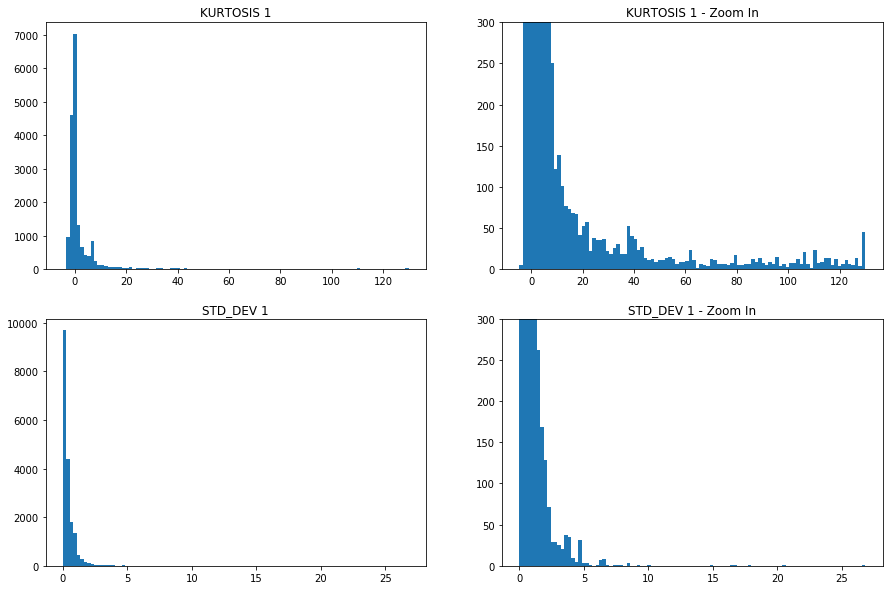

In [18]:
### Kurtosis and Std_dev distribution
plt.figure(figsize=(15,10))

plt.subplot(221, title = "KURTOSIS 1")
plt.hist(metrics_1['KURT'], bins = 100)

plt.subplot(222, title = "KURTOSIS 1 - Zoom In")
plt.hist(metrics_1['KURT'], bins = 100)
plt.ylim((0,300))

plt.subplot(223, title = "STD_DEV 1")
plt.hist(metrics_1['SD'], bins = 100)

plt.subplot(224, title = "STD_DEV 1 - Zoom In")
plt.hist(metrics_1['SD'], bins = 100)
plt.ylim((0,300))

Text(0, 0.5, 'Kurtosis')

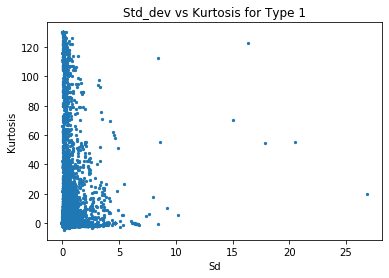

In [20]:
### Scatter plot of SD vs Kurtosis
plt.scatter(metrics_1['SD'],metrics_1['KURT'],s=5)
plt.title("Std_dev vs Kurtosis for Type 1")
plt.xlabel("Sd")
plt.ylabel("Kurtosis")

## Using Quantile as Threshold

In [21]:
# Check quantile
thres_kurt = metrics_1['KURT'].quantile(0.95)
thres_sd = metrics_1['SD'].quantile(0.95)
print(thres_kurt)
print(thres_sd)

30.459771149782004
1.2972021146394983


In [22]:
# Filter products according to thresholds above
products_filter = metrics_1[(metrics_1['KURT']>=thres_kurt) & (metrics_1['SD']>=thres_sd)]
print('Num of Products filtered out: ', len(products_filter))
products_filter['Filter'] = 1
# Join
metrics_1 = metrics_1.join(products_filter['Filter'],how='left')
metrics_1['Filter'].fillna(0,inplace=True)

Num of Products filtered out:  80


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


(-1, 30)

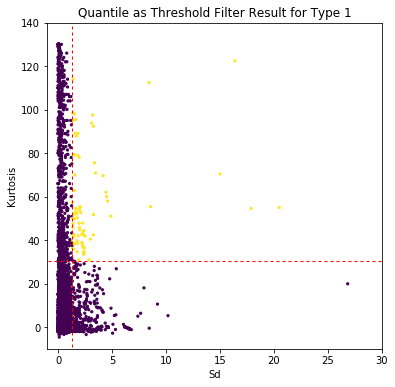

In [23]:
# Plot
plt.figure(figsize=(6,6))
plt.scatter(metrics_1['SD'],metrics_1['KURT'],s=5,c=metrics_1['Filter'])
plt.title("Quantile as Threshold Filter Result for Type 1")
plt.xlabel("Sd")
plt.ylabel("Kurtosis")
plt.plot([thres_sd, thres_sd], [-20,140], 'k-', lw=1,dashes=[3,3], c='red')
plt.plot([-2, 30], [thres_kurt,thres_kurt], 'k-', lw=1,dashes=[3,3], c='red')
plt.ylim(-10,140)
plt.xlim(-1,30)

In [25]:
# Flag the products filtered out
metrics_1[metrics_1['Filter']==1].head(5)

KURT        SD  Filter
STORE_ID PRODUCT_ID                             
01       0512        36.632510  2.331381     1.0
02       0179        42.600312  2.192510     1.0
         0210        70.880084  3.475996     1.0
         0512        42.454087  2.361485     1.0
         0632        93.869498  3.114801     1.0

## Clustering Algorithms

### Kmeans

In [26]:
from sklearn.cluster import KMeans
metrics_1.dropna(inplace=True)
kmeans = KMeans(n_clusters=3, random_state=0).fit(metrics_1[['KURT','SD']])

metrics_1['Kmeans'] = kmeans.labels_

In [27]:
metrics_1['Kmeans'].value_counts()

0    17181
2      821
1      439
Name: Kmeans, dtype: int64

Text(0, 0.5, 'Kurtosis')

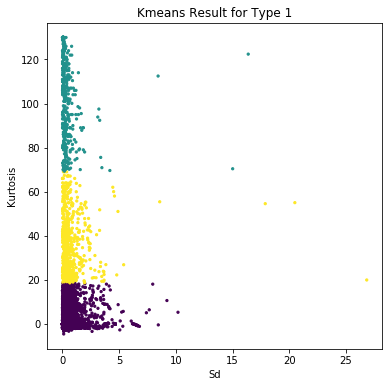

In [28]:
# Plot
plt.figure(figsize=(6,6))
plt.scatter(metrics_1['SD'],metrics_1['KURT'],s=5,c=metrics_1['Kmeans'])
plt.title("Kmeans Result for Type 1")
plt.xlabel("Sd")
plt.ylabel("Kurtosis")

### MeanShift

In [29]:
from sklearn.cluster import MeanShift
MeanShift = MeanShift().fit(metrics_1[['KURT','SD']])

metrics_1['MeanShift'] = MeanShift.labels_

In [30]:
metrics_1['MeanShift'].value_counts()

0     17205
1       605
2       123
6        95
4        90
3        90
7        63
9        59
8        55
5        49
14        2
10        2
13        1
12        1
11        1
Name: MeanShift, dtype: int64

Text(0, 0.5, 'Kurtosis')

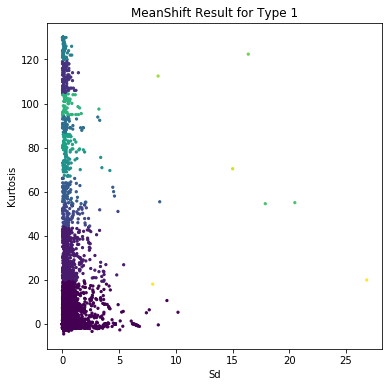

In [31]:
# Plot
plt.figure(figsize=(6,6))
plt.scatter(metrics_1['SD'],metrics_1['KURT'],s=5,c=metrics_1['MeanShift'])
plt.title("MeanShift Result for Type 1")
plt.xlabel("Sd")
plt.ylabel("Kurtosis")

### DBSCAN

In [32]:
from sklearn.cluster import DBSCAN
DBSCAN = DBSCAN(eps=1.5, min_samples=5).fit(metrics_1[['KURT','SD']])

metrics_1['DBSCAN'] = DBSCAN.labels_

In [33]:
metrics_1['DBSCAN'].value_counts()

 0    17969
 2      433
-1       28
 1       11
Name: DBSCAN, dtype: int64

In [34]:
def unique_list(l):
    x = []
    for a in l:
        if a not in x:
            x.append(a)
    return x

unique_list(list(DBSCAN.labels_))

[0, 1, 2, -1]

Text(0, 0.5, 'Kurtosis')

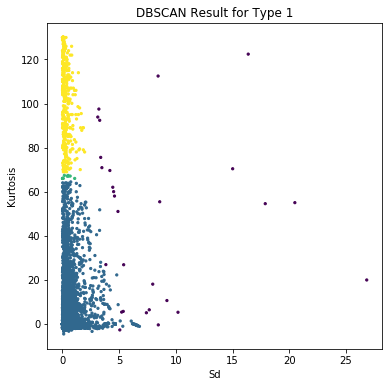

In [35]:
# Plot
plt.figure(figsize=(6,6))
plt.scatter(metrics_1['SD'],metrics_1['KURT'],s=5,c=metrics_1['DBSCAN'])
plt.title("DBSCAN Result for Type 1")
plt.xlabel("Sd")
plt.ylabel("Kurtosis")

In [36]:
# Flag the products filtered out by DBSCAN
metrics_1[metrics_1['DBSCAN']== -1].head()

KURT         SD  Filter  Kmeans  MeanShift  DBSCAN
STORE_ID PRODUCT_ID                                                         
02       0210        70.880084   3.475996     1.0       1          7      -1
         0632        93.869498   3.114801     1.0       1          5      -1
         1031        54.531122  17.875436     1.0       2         10      -1
         1038        58.000000   4.587847     1.0       2          4      -1
03       1038        26.857802   3.827462     0.0       2          1      -1